In [1]:
from collections import Counter
import glob
from lifelines import KaplanMeierFitter
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
EVEROLIMUS = "C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)OCCO)C)/C)O)OC)C)C)/C)OC"
RIBOCICLIB = "CN(C)C(=O)C1=CC2=CN=C(N=C2N1C3CCCC3)NC4=NC=C(C=C4)N5CCNCC5"

In [4]:
def generate_test_data(genie_data, mutation_data, drugs):
    
    #cell_lines = genie_data.query('`CDK4/6 Inhibitor Overall` == "Yes" or `mTOR Inhibitor Overall` == "Yes"')
    #cell_lines = sorted(cell_lines['Sample ID'])
    cell_lines = sorted(genie_data['Sample ID'])
    cell_line_df = pd.DataFrame(cell_lines, columns=['C'])
    
    filtered_mut_data = mutation_data.query('sampleId in @cell_lines')
    filtered_mut_data = filtered_mut_data.sort_values(by=['sampleId'])
    filtered_mut_data = filtered_mut_data.drop(columns=['sampleId', 'Altered'])
    
    test_data = []
    for d in drugs:
        for c in cell_lines:
            test_data.append((c, d, 0.5))
    test_data_df = pd.DataFrame(test_data, columns=['C', 'D', 'AUC'])
    
    return cell_line_df, filtered_mut_data, test_data_df

In [5]:
def generate_cell_mutation_file(all_genie_genes, other_genes, genie_data, all_mutation_data):
    
    #cell_lines = genie_data.query('`CDK4/6 Inhibitor Overall` == "Yes" or `mTOR Inhibitor Overall` == "Yes"')
    #cell_lines = sorted(cell_lines['Sample ID'])
    cell_lines = sorted(genie_data['Sample ID'])

    filtered_mut_data = all_mutation_data.query('sampleId in @cell_lines')
    filtered_mut_data = filtered_mut_data.sort_values(by=['sampleId'])
    filtered_mut_data.drop(columns=['sampleId', 'Altered'], inplace=True)
    
    non_overlapping_genes_AnotB = [g for g in all_genie_genes if g not in other_genes] #A-B
    
    filtered_mut_data.drop(columns=non_overlapping_genes_AnotB, inplace=True)
    
    non_overlapping_genes_BnotA = [g for g in other_genes if g not in all_genie_genes] #B-A
    
    for gene in non_overlapping_genes_BnotA:
        filtered_mut_data[gene] = 0
        
    filtered_mut_data.sort_index(inplace=True, axis=1)
    
    return filtered_mut_data

In [26]:
def create_survival_plot(g_data, test_data, predict_data):
    
    genie_data = g_data.query('`CDK4/6 Inhibitor Overall` == "Yes" or `mTOR Inhibitor Overall` == "Yes"')
    genie_data = genie_data.sort_values(by=['Sample ID'])
    
    pred_df = pd.Series(predict_data, name='P_AUC')
    pred_df = pd.concat([test_data, pred_df], axis=1)[['C', 'D', 'P_AUC']]
    
    #d_list = [RIBOCICLIB, EVEROLIMUS]
    pred_median_dict = pred_df.groupby('D')['P_AUC'].median().to_dict()
    print(pred_median_dict)
    #pred_median = np.median(pred_df.query('D in @d_list')['P_AUC'])
    #print(pred_median)
    
    dc_p = []
    dc_n = []
    
    for _,row in genie_data.iterrows():
        
        cell_line = row['Sample ID']
        df = pred_df.query('C == @cell_line')
        dp_map = dict(zip(df.D, df.P_AUC))
        
        is_positive = False
        if row['CDK4/6 Inhibitor Overall'] == 'Yes' and row['mTOR Inhibitor Overall'] == 'Yes':
            if dp_map[RIBOCICLIB] <= pred_median_dict[RIBOCICLIB] or dp_map[EVEROLIMUS] <= pred_median_dict[EVEROLIMUS]:
                is_positive = True
        elif row['CDK4/6 Inhibitor Overall'] == 'Yes':
            if dp_map[RIBOCICLIB] <= pred_median_dict[RIBOCICLIB]:
                is_positive = True
        elif row['mTOR Inhibitor Overall'] == 'Yes':
            if dp_map[EVEROLIMUS] <= pred_median_dict[EVEROLIMUS]:
                is_positive = True
        else:
            print('This code should have been unreachable')
            continue
        
        if is_positive:
            dc_p.append(row['Overall Survival (Months)'])
        else:
            dc_n.append(row['Overall Survival (Months)'])

    print('DrugCell(+) count:', len(dc_p))
    print('DrugCell(-) count:', len(dc_n))
            
    kmf = KaplanMeierFitter()
    kmf.fit(dc_p, label='DrugCell(+)')
    print('DrugCell(+) median:', kmf.median_survival_time_)
    a1 = kmf.plot(ci_show=False)
    kmf.fit(dc_n, label='DrugCell(-)')
    print('DrugCell(-) median:', kmf.median_survival_time_)
    a1 = kmf.plot(ci_show=False)
    a1.set_xlim(0, 120)
    a1.set_xlabel('Overall Survival (Months)')
    a1.set_ylabel('Surviving Fractions')

In [7]:
genie_data = pd.read_csv('../data/GENIE/brca_akt1_genie_2019_clinical_data.tsv', sep='\t')

nest_mutation_data = pd.read_csv('../data/GENIE/sample_matrix_nest.txt', sep='\t')
nest_mutation_data['sampleId'] = nest_mutation_data['studyID:sampleId'].str.split(":", expand=True)[1]
nest_mutation_data.drop(columns =['studyID:sampleId'], inplace = True)

all_mutation_data = pd.read_csv('../data/GENIE/sample_matrix_all_genes.txt', sep='\t')
all_mutation_data['sampleId'] = all_mutation_data['studyID:sampleId'].str.split(":", expand=True)[1]
all_mutation_data.drop(columns =['studyID:sampleId'], inplace = True)

drugs = pd.read_csv('../data/GENIE/GENIE_all_drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']

test_data = pd.read_csv('../data/GENIE/GENIE_test.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])

all_genie_genes = pd.read_csv('../data/GENIE/GENIE_gene_list.txt', header=None, names=['G'])['G']

drugcell_genes = pd.read_csv('../../drugcell/data/gene2ind.txt', sep='\t', header=None, names=['I', 'G'])['G']

In [8]:
cell_lines, filtered_mut_data, test_data = generate_test_data(genie_data, nest_mutation_data, drugs)

cell_lines.to_csv('../data/GENIE/GENIE_all_cell2ind.txt', sep='\t', header=False, index=True)
filtered_mut_data.to_csv('../data/GENIE/GENIE_all_cell2mutation.txt', header=False, index=False)
test_data.to_csv("../data/GENIE/GENIE_all_test.txt", sep='\t', header=False, index=False)

In [9]:
filtered_mut_data = generate_cell_mutation_file(list(all_genie_genes), list(drugcell_genes), genie_data, all_mutation_data)

filtered_mut_data.to_csv('../../drugcell/data/GENIE_all_cell2mutation.txt', header=False, index=False)
cell_lines.to_csv('../../drugcell/data/GENIE_all_cell2ind.txt', sep='\t', header=False, index=True)
test_data.to_csv("../../drugcell/data/GENIE_all_test.txt", sep='\t', header=False, index=False)

In [ ]:
new_predict_data = np.loadtxt('../result/predict_genie_clinical_trial.txt')

create_survival_plot(genie_data, test_data, new_predict_data)

In [ ]:
new_drugcell_predict_data = np.loadtxt('../../drugcell/result/predict_genie_drugcell.txt')
create_survival_plot(genie_data, test_data, new_drugcell_predict_data)

{'C1CN(CCC1(C(=O)N[C@@H](CCO)C2=CC=C(C=C2)Cl)N)C3=NC=NC4=C3C=CN4': 0.69804, 'CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C': 0.71011, 'CN(C)C(=O)C1=CC2=CN=C(N=C2N1C3CCCC3)NC4=NC=C(C=C4)N5CCNCC5': 0.68126, 'C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)OCCO)C)/C)O)OC)C)C)/C)OC': 0.63202, 'C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)[C@@H](CC4=C3C=CC(=C4)O)CCCCCCCCCS(=O)CCCC(C(F)(F)F)(F)F': 0.91891}
0.6600600000000001
DrugCell(+) count: 115
DrugCell(-) count: 106
DrugCell(+) median: 43.19078947
DrugCell(-) median: 37.66447368


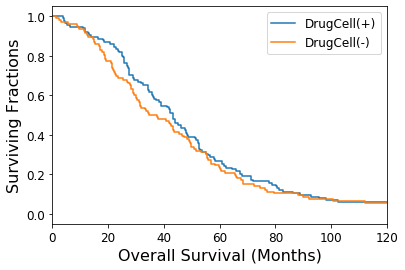

In [28]:
new_predict_data = np.loadtxt('../result/predict_genie_all_clinical_trial.txt')

create_survival_plot(genie_data, test_data, new_predict_data)

{'C1CN(CCC1(C(=O)N[C@@H](CCO)C2=CC=C(C=C2)Cl)N)C3=NC=NC4=C3C=CN4': 0.69895, 'CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C': 0.716205, 'CN(C)C(=O)C1=CC2=CN=C(N=C2N1C3CCCC3)NC4=NC=C(C=C4)N5CCNCC5': 0.71037, 'C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)OCCO)C)/C)O)OC)C)C)/C)OC': 0.6401650000000001, 'C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)[C@@H](CC4=C3C=CC(=C4)O)CCCCCCCCCS(=O)CCCC(C(F)(F)F)(F)F': 0.92076}
0.673755
DrugCell(+) count: 121
DrugCell(-) count: 100
DrugCell(+) median: 36.41447368
DrugCell(-) median: 45.55921053


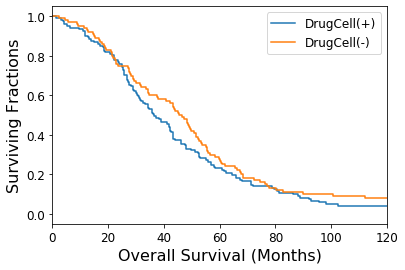

In [27]:
new_drugcell_predict_data = np.loadtxt('../../drugcell/result/predict_genie_all_drugcell.txt')
create_survival_plot(genie_data, test_data, new_drugcell_predict_data)